# Book rating regression project

## Loading the dataset

In [1]:
import pandas as pd

In [2]:
raw_df = pd.read_csv(
    filepath_or_buffer="data/books.csv",
    on_bad_lines="warn",
    sep=",",
    skipinitialspace=True,
)

Skipping line 3350: expected 12 fields, saw 13
Skipping line 4704: expected 12 fields, saw 13
Skipping line 5879: expected 12 fields, saw 13
Skipping line 8981: expected 12 fields, saw 13



We notice how some rows had too many fields. The `on_bad_lines="warn"` argument skips them for us. When we go look at those rows in the csv file, we notice that some books had comas `,` in their title or authors names.
For example for line 3350 is as follows:
`12224,Streetcar Suburbs: The Process of Growth in Boston  1870-1900,Sam Bass Warner, Jr./Sam B. Warner,3.58,0674842111,9780674842113,en-US,236,61,6,4/20/2004,Harvard University Press`
The author name is contains a coma `Sam Bass Warner, Jr./Sam B. Warner`.

We will skip those lines for now.

In [3]:
raw_df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [4]:
raw_df.shape

(11123, 12)

In [5]:
raw_df.authors.describe()

count            11123
unique            6639
top       Stephen King
freq                40
Name: authors, dtype: object

In [6]:
raw_df.title.describe()

count         11123
unique        10348
top       The Iliad
freq              9
Name: title, dtype: object

Checking for NA values:

In [7]:
raw_df.isna().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

Great, we have no NA values. The dataset is now clean

In [8]:
df = raw_df

In [9]:
df.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,32104.500000,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


## Preliminary analysis

**Questions:**
- Is the data balanced?
- Which features are useful and which aren't?

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

We will plot the distributions of the main numerical features:
- number of pages
- number of ratings
- number of reviews
- average rating

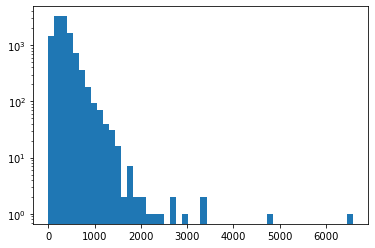

In [11]:
plt.hist(df["num_pages"], bins=50)
plt.yscale("log")
plt.show()

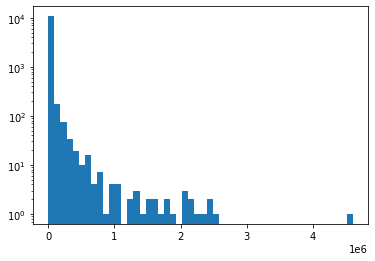

In [12]:
plt.hist(df["ratings_count"], bins=50)
plt.yscale("log")
plt.show()

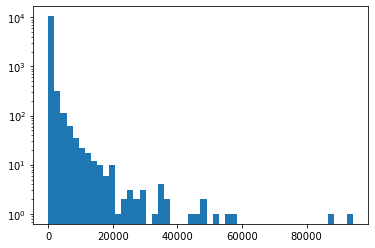

In [13]:
plt.hist(df["text_reviews_count"], bins=50)
plt.yscale("log")
plt.show()

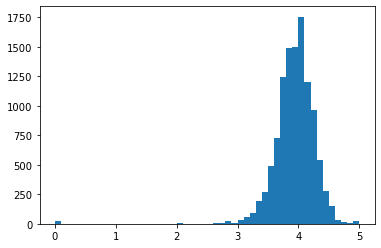

In [14]:
plt.hist(df["average_rating"], bins=50)
plt.show()

We notice immediately that the target feature `average_rating` is skewed towards an average of 4. It resembles a normal distribution.
We will have to take this into consideration when creating the training and testing sets: these sets should both include books with a wide range of average ratings.

In [15]:
corr_matrix = df.corr()

/tmp/ipykernel_171497/3147368345.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


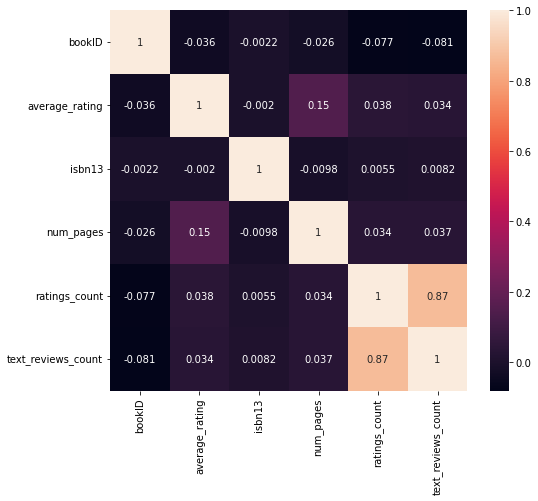

In [16]:
plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True)
plt.show()

We are particularly interested in the correlations between `average_rating` and other features. We make a few observations:
- `average_rating` has no substantial correlation with `isnb13` which should be expected
- `average_rating` slighty correlates with `ratings_count` and `text_reviews_count`. Meaning that on average, books with more ratings and reviews tend to have slightly better ratings
- `average_rating` correlates positively with `num_pages` in decent amounts
- `average_rating` slighty correlates negatively with `bookID`. This has no reason to be the case and is likely just noise from the random ordering of the dataset.

In the next section, we will try to see if the age of the book could be an interesting feature. In particular, does the age of the book have an impact on the average rating ?

In [17]:
from datetime import datetime, MINYEAR, timedelta
from time import strptime

In [18]:
def date_to_datetime(date):
    try:
        new_time_format = datetime.strptime(date, "%m/%d/%Y")
        return new_time_format
    except ValueError:
        newdate = date.split("/")
        if newdate[1] == "31":
            newdate[1] = "30"
        newdate = newdate[0] + "/" + newdate[1] + "/" + newdate[2]
        return datetime.strptime(newdate, "%m/%d/%Y")

In [19]:
df["publication_date"] = df["publication_date"].apply(date_to_datetime)

In [20]:
oldest_book = min(df["publication_date"])
newest_book = max(df["publication_date"])

In [21]:
def normalise_age(book_date):
    return (book_date.timestamp() - oldest_book.timestamp()) / (newest_book.timestamp() - oldest_book.timestamp())


In [22]:
df["normalised_age"] = df["publication_date"].apply(normalise_age)



We have created a feature which describes the age of the book where 0 is the oldest book in the dataset (Consider the Lilies) and 1 is the most recent book (A Quick Bite (Argeneau #1))
Let's look the distribution of book age and how this feature correlates with the average_rating

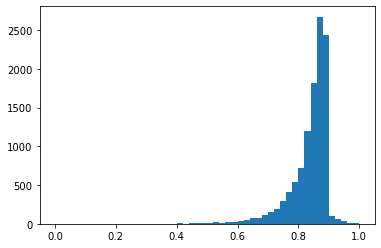

In [23]:
plt.hist(df["normalised_age"], bins=50)
plt.show()

We see that the age distribution isn't balanced. most books from the dataset have been published in the second half of the 20th century.

/tmp/ipykernel_171497/2933625568.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


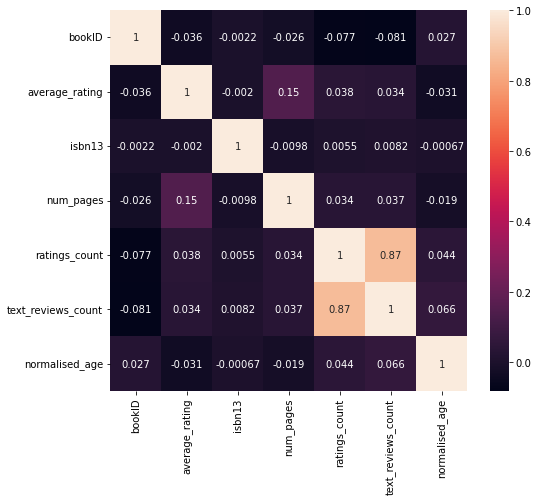

In [24]:
corr_matrix = df.corr()
plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [25]:
print("Correlation between average_rating and age:", round(corr_matrix["average_rating"]["normalised_age"], 3))

Correlation between average_rating and age: -0.031


The `normalised_age` slightly anticorrelates with the average rating. This means that on average, older books have slightly better ratings than more modern books.

In [26]:
df = df.drop("publication_date", axis=1)

## Feature Engineering

We need to figure out which features can be use to predict the `average_rating`. The easy and obvious features are `nb_ratings`, `nb_reviews` and `nb_pages`. What about the book age ? Or the language ? Can we use this data to actually predict the average rating ?

### Removing unused data

In [27]:
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publisher', 'normalised_age'],
      dtype='object')

In [28]:
df = df.drop(["bookID", "isbn", "isbn13"], axis=1)

### Language


In [29]:
unique_languages = list(df["language_code"].unique())
print(unique_languages)

['eng', 'en-US', 'fre', 'spa', 'en-GB', 'mul', 'grc', 'enm', 'en-CA', 'ger', 'jpn', 'ara', 'nl', 'zho', 'lat', 'por', 'srp', 'ita', 'rus', 'msa', 'glg', 'wel', 'swe', 'nor', 'tur', 'gla', 'ale']


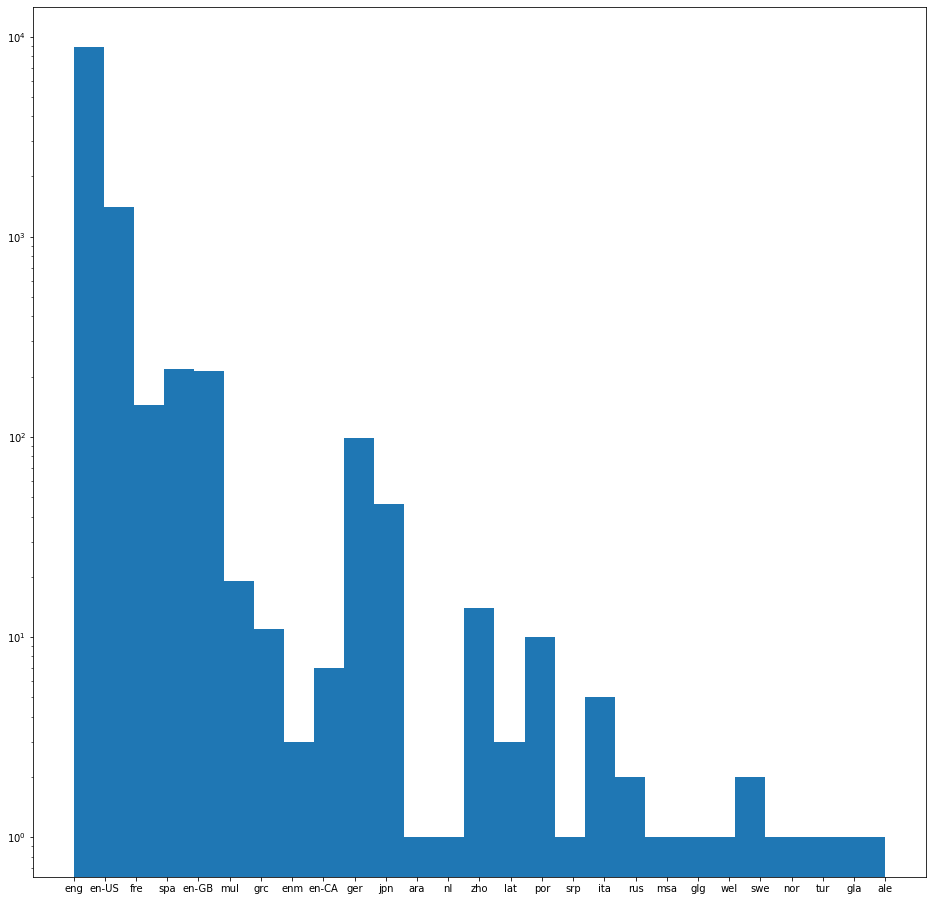

In [30]:
plt.figure(figsize=(16, 16))
plt.hist(df["language_code"], bins=len(unique_languages))
plt.yscale("log")

We notice that most books are written in english. We can maybe make a split "english" / "foreign" ? In addition, we would like to have only numerical values, thus separating it into a binary values (0 for english and 1 for foreign)

In [31]:
def sort_english(language_code):
    if language_code in ['eng', 'en-US', 'en-GB', 'en-CA', "enm"]:
        return 0
    else:
        return 1

In [32]:
df["language"] = df["language_code"].apply(sort_english)

In [33]:
nb_foreign = df[df["language"] == 1].shape[0]
print(f"There are {nb_foreign} foreign books ({round(100 * nb_foreign / df.shape[0], 3)} %)")

There are 583 foreign books (5.241 %)


In [34]:
# Removing original language code data from dataframe 
df = df.drop("language_code", axis=1)

### Title, publisher and author data

Can we use the data containing the author and publisher names and titles ? First let's see how many different authors, publishers and titles we have

In [35]:
tot_publisher = len(df["publisher"].unique())
tot_authors = len(df["publisher"].unique())
tot_titles = len(df["title"].unique())

In [36]:
print(f"There is a total of {tot_authors} authors")
print(f"There is a total of {tot_publisher} publishers")
print(f"There is a total of {tot_titles} titles")

There is a total of 2290 authors
There is a total of 2290 publishers
There is a total of 10348 titles


If we wanted to use this data as features, we would have to convert it to numerical values. There is no practical way to convert tousands of names into quantifiable metrics. Thus, we will not use the titles and publisher and author names in our modeling

In [37]:
# Removing titles, authors and publishers from the dataframe
df = df.drop(["authors", "publisher", "title"], axis=1)

In [38]:
df.columns

Index(['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count',
       'normalised_age', 'language'],
      dtype='object')

### Outliers

In [39]:
df_no_outliers = df.copy()

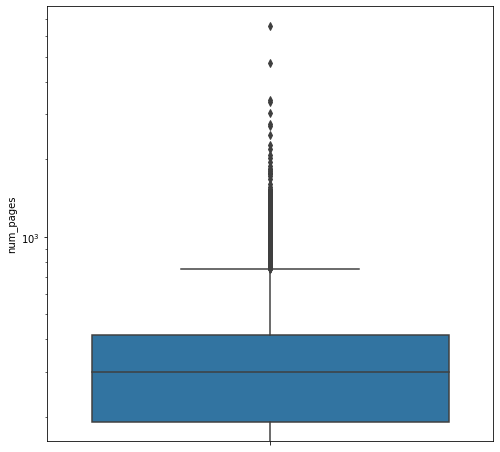

In [40]:
plt.figure(figsize=(8, 8))
sns.boxplot(y=df["num_pages"])
plt.yscale("log")
plt.show()

In [41]:
df[df["num_pages"] > 2e3].shape[0]

12

In [42]:
df_no_outliers = df_no_outliers[df_no_outliers["num_pages"] < 2e3]

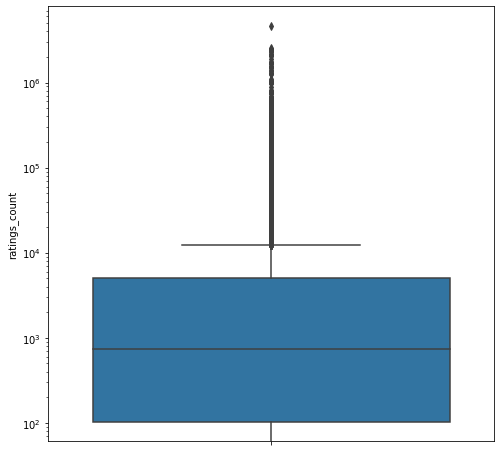

In [43]:
plt.figure(figsize=(8, 8))
sns.boxplot(y=df['ratings_count'])
plt.yscale("log")
plt.show()

In [44]:
df[df["ratings_count"] > 1e5].shape[0]

352

In [45]:
df_no_outliers = df_no_outliers[df_no_outliers["ratings_count"] < 1e5]

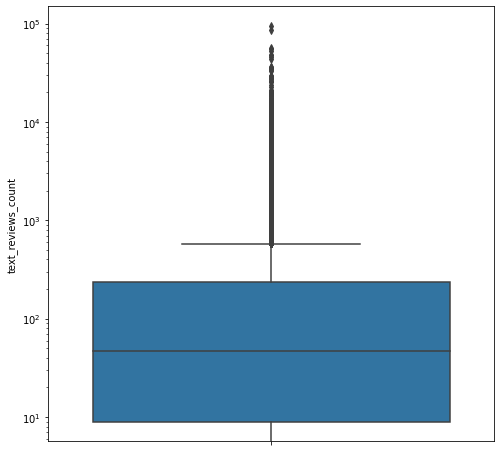

In [46]:
plt.figure(figsize=(8, 8))
sns.boxplot(y=df["text_reviews_count"])
plt.yscale("log")
plt.show()

In [47]:
df[df["text_reviews_count"] > 1e4].shape[0]

94

In [48]:
df_no_outliers = df_no_outliers[df_no_outliers["text_reviews_count"] < 1e4]

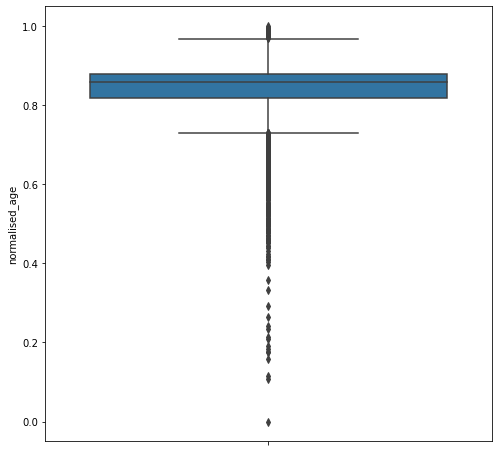

In [49]:
plt.figure(figsize=(8, 8))
sns.boxplot(y=df['normalised_age'])
plt.show()

In [50]:
df[df["normalised_age"] < 0.5].shape[0]

52

In [51]:
df_no_outliers = df_no_outliers[df_no_outliers["normalised_age"] > 0.5]

In [52]:
print(f"We have kept {df_no_outliers.shape[0]} rows of data, ({round(100 * df_no_outliers.shape[0] / df.shape[0], 2)} %)")

We have kept 10708 rows of data, (96.27 %)


After removing outliers, we have a total of 10708 rows, which is enough to do substantial machine learnign modeling

In [53]:
df.columns

Index(['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count',
       'normalised_age', 'language'],
      dtype='object')

### Conclusion

We have kept the following features:
- average_rating (target feature)
- num_pages
- ratings_count
- text_reviews_count
- normalised_age
- language

## Data modeling 

In order to predict the `average_rating`, we're going to split our dataset in two to have a first trainning set and a second test set. We'll also divide our data in two: on the one hand, the explanatory variables: 

- `num_pages`
- `ratings_count`
- `text_reviews_count`
- `normalised_age`
- `language`

and on the other hand, the variable to be predicted: `average_rating`

In [54]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, max_error, mean_squared_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt

Giving 20% for test and 80% for training

In [55]:
df_train, df_test =  train_test_split(df, test_size = 0.2, random_state=42)

In [56]:
print(len(df))
print(len(df_test))
len(df_train)

11123
2225


8898

In [57]:
df_train.columns

Index(['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count',
       'normalised_age', 'language'],
      dtype='object')

In [58]:
# get the values of the explanatory variables for the training data
X_train = df_train.loc[:,['num_pages', 'ratings_count', 'text_reviews_count',
       'normalised_age', 'language']].values
#the values of the variable to be predicted 
y_train = df_train.average_rating.values

# get the values of the explanatory variables  for the test data
X_test = df_test.loc[:,['num_pages', 'ratings_count', 'text_reviews_count',
       'normalised_age', 'language']].values
#the values of the variable to be predicted 
y_test = df_test.average_rating.values

In [59]:
df_test.average_rating.values

array([3.85, 3.97, 3.92, ..., 4.  , 3.75, 4.32])

In [60]:
#here we create linear regression model and train it 
RF_model = RandomForestRegressor(
    n_estimators=100,
)
RF_model.fit(X_train, y_train)
RF_predict = RF_model.predict(X_test)

### Let's plot  the result

In [61]:
from sklearn.metrics import mean_absolute_error, max_error, mean_squared_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt


def evaluate_model(y_true, y_predict, model_name, model_parameters="", plot_sample=True, scatter_plot=True):
    print(f"Evaluating {model_name} model", end=" ")
    if model_parameters != "":
        print(f"with parameters :\n{model_parameters}")
    
    if plot_sample:
        fig = pd.DataFrame({'Real': y_test.tolist(), 'Predicted': y_predict.tolist()}).head(20)
        fig.plot(kind='bar', figsize=(8, 4))
    
    if scatter_plot:
        plt.figure(figsize=(8, 8))
        plt.plot(y_test, y_predict, ls="", marker="x", ms=2)
        plt.plot([0, 5],[0, 5], alpha=0.5)
        plt.xlabel("Real values")
        plt.ylabel("Predicted values")
        plt.xlim([0, 5])
        plt.ylim([0, 5])
        plt.show()

    evaluation = dict()
    
    evaluation["RMSE"] = mean_squared_error(y_true, y_predict, squared=False)
    evaluation["absolute_error"] = mean_absolute_error(y_true, y_predict)
    evaluation["max_error"] = max_error(y_true, y_predict)
    evaluation["r2_score"] = r2_score(y_true, y_predict)
    evaluation["explained_variance_score"] = explained_variance_score(y_true, y_predict)
    
    for key in evaluation.keys():
        print(f"{key} : {round(evaluation[key], 3)}")
    
    return evaluation

Evaluating Random Forest model with parameters :
n_predictors: 100
5 features


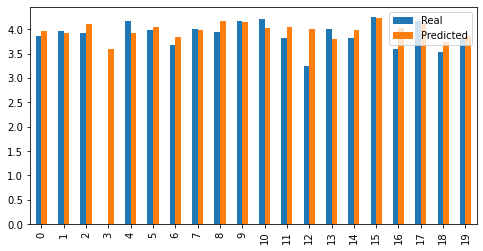

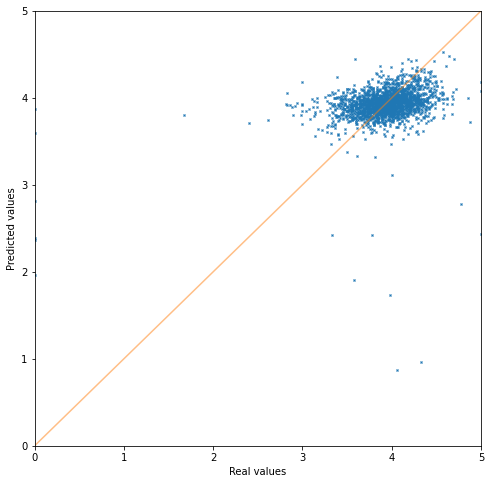

RMSE : 0.345
absolute_error : 0.224
max_error : 3.873
r2_score : 0.057
explained_variance_score : 0.057


In [62]:
random_forest_eval = evaluate_model(y_test, RF_predict, "Random Forest", "n_predictors: 100\n5 features")

In [63]:
# get the values of the explanatory variables for the training data
X_train_2 = df_train.loc[:,['num_pages', 'ratings_count', 'text_reviews_count',]].values
#the values of the variable to be predicted 
y_train_2 = df_train.average_rating.values

# get the values of the explanatory variables  for the test data
X_test_2 = df_test.loc[:,['num_pages', 'ratings_count', 'text_reviews_count',]].values
#the values of the variable to be predicted 
y_test_2 = df_test.average_rating.values


RF_model_2 = RandomForestRegressor(
    n_estimators=100,
)
RF_model_2.fit(X_train_2, y_train_2)
RF_predict_2 = RF_model_2.predict(X_test_2)

Evaluating Random Forest model with parameters :
n_predictors: 100
3 features


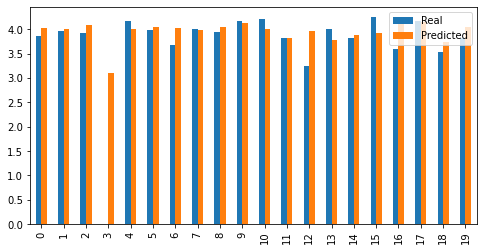

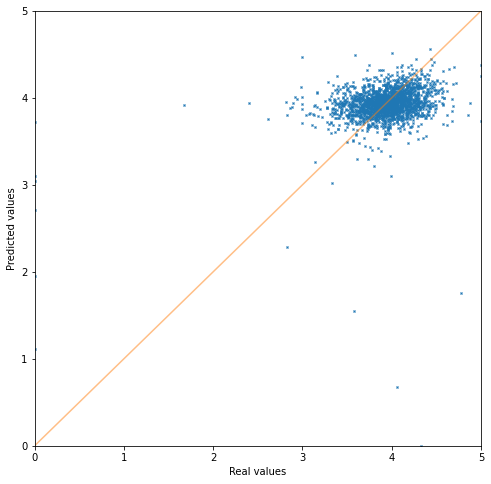

RMSE : 0.352
absolute_error : 0.231
max_error : 4.33
r2_score : 0.015
explained_variance_score : 0.015


In [64]:
random_forest_eval_2 = evaluate_model(y_test_2, RF_predict_2, "Random Forest", "n_predictors: 100\n3 features")

In [65]:
print(random_forest_eval)
print(random_forest_eval_2)

{'RMSE': 0.34499854863072016, 'absolute_error': 0.2240064269662922, 'max_error': 3.873400000000001, 'r2_score': 0.05660778606829775, 'explained_variance_score': 0.05664543216917384}
{'RMSE': 0.3524673155529217, 'absolute_error': 0.2305402119850187, 'max_error': 4.33, 'r2_score': 0.015319237612082426, 'explained_variance_score': 0.015335138635661938}


### Gradient Boosting

In [66]:
from sklearn.ensemble import GradientBoostingRegressor

In [67]:
# get the values of the explanatory variables for the training data
X_train = df_train.loc[:,['num_pages', 'ratings_count', 'text_reviews_count',
       'normalised_age', 'language']].values
#the values of the variable to be predicted 
y_train = df_train.average_rating.values

# get the values of the explanatory variables  for the test data
X_test = df_test.loc[:,['num_pages', 'ratings_count', 'text_reviews_count',
       'normalised_age', 'language']].values
#the values of the variable to be predicted 
y_test = df_test.average_rating.values

In [68]:
params = {
#    "n_estimators": 1000,
#    "max_depth": 3,
#    "min_samples_split": 10,
#    "learning_rate": 0.01,
#    "loss": "squared_error",
    "alpha": 0.7, 
}


GB_model = GradientBoostingRegressor(**params)

GB_model.fit(X_train, y_train)
GB_predict = GB_model.predict(X_test)

Evaluating Gradient Boosting model with parameters :
parameters = {'alpha': 0.7}


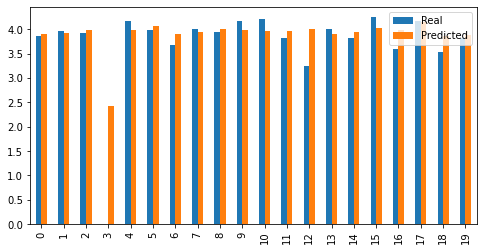

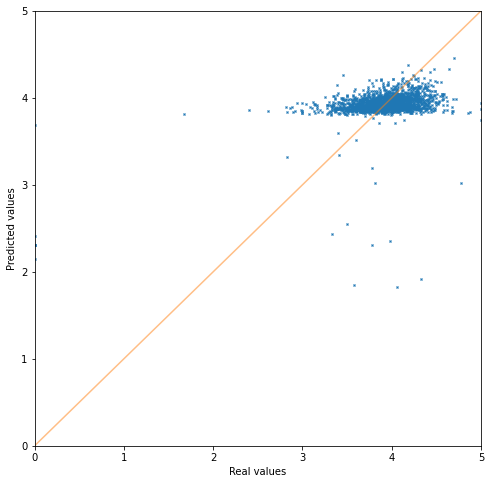

RMSE : 0.324
absolute_error : 0.22
max_error : 3.685
r2_score : 0.17
explained_variance_score : 0.17


In [69]:
gradient_boosting_eval = evaluate_model(y_test, GB_predict, "Gradient Boosting", f"parameters = {params}")

## Lasso

In [70]:
from sklearn.linear_model import Lasso

In [71]:
# get the values of the explanatory variables for the training data
X_train = df_train.loc[:,['num_pages', 'ratings_count', 'text_reviews_count',
       'normalised_age', 'language']].values
#the values of the variable to be predicted 
y_train = df_train.average_rating.values

# get the values of the explanatory variables  for the test data
X_test = df_test.loc[:,['num_pages', 'ratings_count', 'text_reviews_count',
       'normalised_age', 'language']].values
#the values of the variable to be predicted 
y_test = df_test.average_rating.values

In [72]:
params = {
    "alpha": 0.5
}


lasso_model = Lasso(**params)

lasso_model.fit(X_train, y_train)
lasso_predict = lasso_model.predict(X_test)

Evaluating Lasso regression model with parameters :
parameters = {'alpha': 0.5}


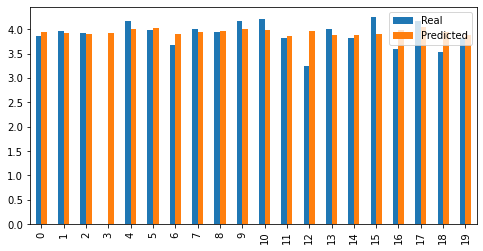

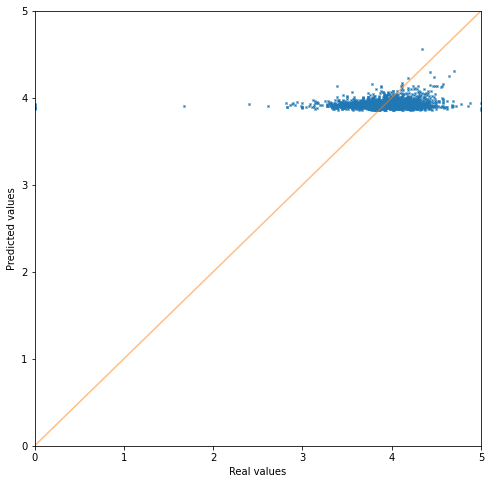

RMSE : 0.351
absolute_error : 0.227
max_error : 3.925
r2_score : 0.026
explained_variance_score : 0.026


In [73]:
lasso_eval = evaluate_model(y_test, lasso_predict, "Lasso regression", f"parameters = {params}")

## SVM : linear kernel

Seems to be running forever, Python monopolises one full CPU core

In [74]:
from sklearn.svm import SVR

In [75]:
# get the values of the explanatory variables for the training data
X_train = df_train.loc[:,['num_pages', 'ratings_count', 'text_reviews_count',
       'normalised_age', 'language']].values
#the values of the variable to be predicted 
y_train = df_train.average_rating.values

# get the values of the explanatory variables  for the test data
X_test = df_test.loc[:,['num_pages', 'ratings_count', 'text_reviews_count',
       'normalised_age', 'language']].values
#the values of the variable to be predicted 
y_test = df_test.average_rating.values

## SVM : rbf kernel

In [78]:
params = {
    "kernel": "rbf",
    "gamma": "auto"
}


SVR_model = SVR(**params)

SVR_model.fit(X_train, y_train)
SVR_predict = SVR_model.predict(X_test)

Evaluating SVR regression model with parameters :
parameters = {'kernel': 'rbf', 'gamma': 'auto'}


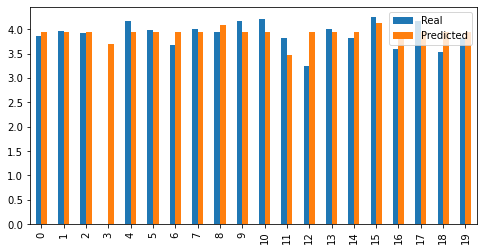

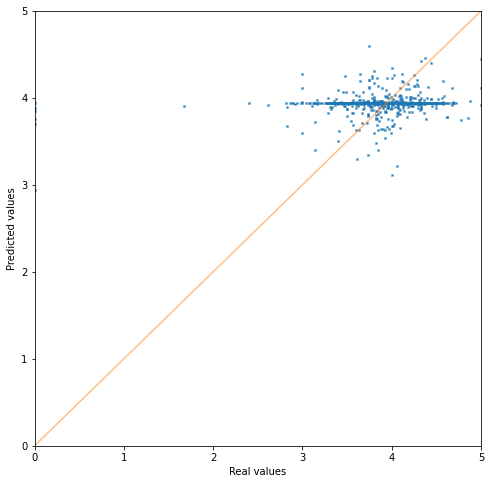

RMSE : 0.35
absolute_error : 0.232
max_error : 3.939
r2_score : 0.028
explained_variance_score : 0.029


In [79]:
SVR_eval = evaluate_model(y_test, SVR_predict, "SVR regression", f"parameters = {params}")